Paired TAM (transcient abnormal myleoproliferation) vs AML (acute myeloid leukemia) analysis of patients with the co-occuring condition of Down Syndrome using DESeq2 on IJC counts obtained from rMATS analysis.

Using a matrix constructed from Kids First Workflow V4 done on single runs, a series of scripts were created and are stored in this repository.  For each of the splicing types, all the runs considered for analysis are pooled and normalized to have a non-redundant set of splicing events.  A matrix is then constructed for each of the samples to be analyzed.  

Each splicing type has a bed file for visualizaiton in UCSC Genome browser of all the events, as well as created a matrix of the single runs normalized to the non-redundant union of files.  Both the source and the normalized bed file are available to ensure interprebility of results. 

Using associative arrays in an awk script, it was a rapid way to transform the individual counts from each of the individual runs into a matrix that facilitated analysis.

Using annotations obtained from the rMATS run that provided the coordinates of each of the splicing events as well as the gene that the junctions came from and the count of the reads that overlapped the junctions.   
 
Limma in this notebook is used to perform analysis of these junction counts provided by the rMATS routine.  Using these counts as junction expression.

Between the splicing event differences and the expression differences, between paired samples, biological functional differences may be obtained.

In [1]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager", repos = "https://cloud.r-project.org")


Bioconductor version '3.18' is out-of-date; the current release version '3.19'
  is available with R version '4.4'; see https://bioconductor.org/install



In [2]:
BiocManager::install("dplyr")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.22), R 4.3.3 (2024-02-29)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'dplyr'”
Old packages: 'bbmle', 'BH', 'BiocManager', 'bslib', 'cachem', 'coda',
  'codetools', 'cpp11', 'crosstalk', 'curl', 'data.table', 'DESeq2', 'edgeR',
  'evaluate', 'farver', 'fastmap', 'GenomeInfoDb', 'ggplot2', 'gtable',
  'highr', 'htmlwidgets', 'KernSmooth', 'knitr', 'lifecycle', 'munsell',
  'mvtnorm', 'openssl', 'plotly', 'RcppArmadillo', 'repr', 'rlang',
  'rmarkdown', 'S4Arrays', 'scales', 'segmented', 'SparseArray', 'stringi',
  'stringr', 'tidyselect', 'tinytex', 'withr', 'xfun', 'zlibbioc'



In [3]:
library(Glimma)
library(dplyr)
library(edgeR)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: limma



In [10]:
setwd("/Users/annedeslattesmays/Desktop/projects/post-rmats-single-run/paired.TAM.AMLv2/A5SS_calculate/")


In [11]:
getwd()


[1] "/Users/annedeslattesmays/Desktop/projects/post-rmats-single-run/paired.TAM.AMLv2/A5SS_calculate"

In [12]:
cts <- as.matrix(read.csv("A5SS.IJC.w.coordinates.matrix.csv",sep=",",row.names="ID"))

In [13]:
cts[1:3,11:dim(cts)[2]]

,PAUVKY.03A,PAUVKY.40A,PAWHSD.03A,PAWHSD.40A,PAWSNZ.03A,PAWSNZ.40A,X_1_PAUTLA.03A,X_1_PAUTLA.40A,X_1_PAVUDU.03A,X_1_PAVUDU.40A
1,21,12,0,0,22,0,12,13,0,23
2,4,2,0,0,0,0,5,5,8,3
3,0,0,0,0,0,0,0,0,0,10


In [14]:
featureData <- data.frame(cts[,1:10])
featureData[1:3,]

,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSG00000122435.11,TRMT13,chr1,+,100140407,100141019,100140407,100140514,100143136,100143209
2,ENSG00000121957.15,GPSM2,chr1,+,108918612,108919150,108918612,108918789,108922416,108922576
3,ENSG00000116299.17,ELAPOR1,chr1,+,109173473,109173579,109173473,109173557,109173687,109173837


In [15]:
featureData <- featureData[,c(1,2)]

In [16]:
head(featureData,2)

,GeneID,geneSymbol
,<chr>,<chr>
1,ENSG00000122435.11,TRMT13
2,ENSG00000121957.15,GPSM2


In [17]:
cts <- data.matrix(cts[,11:20])
mode(cts) <- "integer"
is.integer(cts)

[1] TRUE

In [18]:
dim(cts)
head(cts,2)

[1] 6996   10

,PAUVKY.03A,PAUVKY.40A,PAWHSD.03A,PAWHSD.40A,PAWSNZ.03A,PAWSNZ.40A,X_1_PAUTLA.03A,X_1_PAUTLA.40A,X_1_PAVUDU.03A,X_1_PAVUDU.40A
1,21,12,0,0,22,0,12,13,0,23
2,4,2,0,0,0,0,5,5,8,3


In [19]:
colnames(cts) <- c("PAUVKY.03A","PAUVKY.40A","PAWHSD.03A","PAWHSD.40A","PAWSNZ.03A","PAWSNZ.40A","PAUTLA.03A","PAUTLA.40A","PAVUDU.03A","PAVUDU.40A")

The PAWHSD samples are not TAM and AML but in fact TAM and TAM - the resulting heatmap when included showed they clustered together.  We will eliminate them from subsequent analyses.

In [20]:
cts <- cts[,-c(3,4)]

In [21]:
head(cts,2)

,PAUVKY.03A,PAUVKY.40A,PAWSNZ.03A,PAWSNZ.40A,PAUTLA.03A,PAUTLA.40A,PAVUDU.03A,PAVUDU.40A
1,21,12,22,0,12,13,0,23
2,4,2,0,0,5,5,8,3


In [22]:
# Condition 1: Rows with count > 1000 in columns 1, 3, 5, 7
TAM_rows_condition <- rowSums(cts[, c(1, 3, 5, 7)] > 1000) > 0
TAM_matrix<- cts[TAM_rows_condition, c(1, 3, 5, 7)]

# Condition 2: Rows with count > 1000 in columns 2, 4, 6, 8
AML_rows_condition <- rowSums(cts[, c(2, 4, 6, 8)] > 1000) > 0
AML_matrix <- cts[AML_rows_condition, c(2, 4, 6, 8)]

# Combine the sub-matrices by keeping rows that satisfy either condition 1 or condition 2
final_matrix <- cts[AML_rows_condition | TAM_rows_condition, ]

# View the dimensions of the resulting matrices
dim(TAM_matrix)
dim(AML_matrix)
dim(final_matrix)


[1] 192   4

[1] 132   4

[1] 220   8

In [23]:
head(TAM_matrix)
head(AML_matrix)
head(final_matrix)

,PAUVKY.03A,PAWSNZ.03A,PAUTLA.03A,PAVUDU.03A
197,0,0,1141,0
198,0,1095,0,0
248,8847,14271,13061,11508
249,0,0,4822,0
330,1065,1125,1809,1193
331,819,839,1193,956


,PAUVKY.40A,PAWSNZ.40A,PAUTLA.40A,PAVUDU.40A
248,7866,4775,6926,13487
330,951,584,835,1233
332,0,0,0,1202
334,0,588,786,1201
335,2012,1335,1803,3000
456,687,0,0,1917


,PAUVKY.03A,PAUVKY.40A,PAWSNZ.03A,PAWSNZ.40A,PAUTLA.03A,PAUTLA.40A,PAVUDU.03A,PAVUDU.40A
197,0,0,0,0,1141,0,0,0
198,0,0,1095,340,0,0,0,0
248,8847,7866,14271,4775,13061,6926,11508,13487
249,0,0,0,0,4822,0,0,0
330,1065,951,1125,584,1809,835,1193,1233
331,819,567,839,332,1193,453,956,869


In [24]:
cts <- final_matrix

featureData <- featureData[rownames(cts),]

In [25]:
dim(cts)
dim(featureData)

[1] 220   8

[1] 220   2

In [26]:
coldata <- read.csv("/Users/annedeslattesmays/Desktop/projects/post-rmats-single-run/paired.TAM.AMLv2/design_matrix.csv",row.names=1)

In [27]:
coldata


,patient,condition
,<chr>,<chr>
PAUVKY-03A,PAUVKY,TAM
PAUVKY-40A,PAUVKY,AML
PAWSNZ-03A,PAWSNZ,TAM
PAWSNZ-40A,PAWSNZ,AML
PAUTLA-03A,PAUTLA,TAM
PAUTLA-40A,PAUTLA,AML
PAVUDU-03A,PAVUDU,TAM
PAVUDU-40A,PAVUDU,AML


In [28]:
coldata <- coldata[,c("patient","condition")]
coldata$condition <- factor(coldata$condition)
coldata$patient <- factor(coldata$patient)

In [29]:
rownames(coldata)

[1] "PAUVKY-03A" "PAUVKY-40A" "PAWSNZ-03A" "PAWSNZ-40A" "PAUTLA-03A"
[6] "PAUTLA-40A" "PAVUDU-03A" "PAVUDU-40A"

In [30]:
rownames(coldata) <-sub("-",".",rownames(coldata))

In [31]:
colnames(cts)

[1] "PAUVKY.03A" "PAUVKY.40A" "PAWSNZ.03A" "PAWSNZ.40A" "PAUTLA.03A"
[6] "PAUTLA.40A" "PAVUDU.03A" "PAVUDU.40A"

In [32]:
all(rownames(coldata) %in% colnames(cts))

[1] TRUE

In [33]:
dim(cts)
head(cts,4)
mode(cts) <- "integer"
is.integer(cts)

[1] 220   8

,PAUVKY.03A,PAUVKY.40A,PAWSNZ.03A,PAWSNZ.40A,PAUTLA.03A,PAUTLA.40A,PAVUDU.03A,PAVUDU.40A
197,0,0,0,0,1141,0,0,0
198,0,0,1095,340,0,0,0,0
248,8847,7866,14271,4775,13061,6926,11508,13487
249,0,0,0,0,4822,0,0,0


[1] TRUE

In [34]:
# lets look at limma/voom
BiocManager::install("limma")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.22), R 4.3.3 (2024-02-29)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'limma'”
Old packages: 'bbmle', 'BH', 'BiocManager', 'bslib', 'cachem', 'coda',
  'codetools', 'cpp11', 'crosstalk', 'curl', 'data.table', 'DESeq2', 'edgeR',
  'evaluate', 'farver', 'fastmap', 'GenomeInfoDb', 'ggplot2', 'gtable',
  'highr', 'htmlwidgets', 'KernSmooth', 'knitr', 'lifecycle', 'munsell',
  'mvtnorm', 'openssl', 'plotly', 'RcppArmadillo', 'repr', 'rlang',
  'rmarkdown', 'S4Arrays', 'scales', 'segmented', 'SparseArray', 'stringi',
  'stringr', 'tidyselect', 'tinytex', 'withr', 'xfun', 'zlibbioc'



In [35]:
BiocManager::install("statmod")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.22), R 4.3.3 (2024-02-29)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'statmod'”
Old packages: 'bbmle', 'BH', 'BiocManager', 'bslib', 'cachem', 'coda',
  'codetools', 'cpp11', 'crosstalk', 'curl', 'data.table', 'DESeq2', 'edgeR',
  'evaluate', 'farver', 'fastmap', 'GenomeInfoDb', 'ggplot2', 'gtable',
  'highr', 'htmlwidgets', 'KernSmooth', 'knitr', 'lifecycle', 'munsell',
  'mvtnorm', 'openssl', 'plotly', 'RcppArmadillo', 'repr', 'rlang',
  'rmarkdown', 'S4Arrays', 'scales', 'segmented', 'SparseArray', 'stringi',
  'stringr', 'tidyselect', 'tinytex', 'withr', 'xfun', 'zlibbioc'



In [36]:
library(limma)
library(edgeR)
library(statmod)

In [37]:
# making a counts matrix
dge <- DGEList(counts=cts)

In [38]:
colnames(dge)

[1] "PAUVKY.03A" "PAUVKY.40A" "PAWSNZ.03A" "PAWSNZ.40A" "PAUTLA.03A"
[6] "PAUTLA.40A" "PAVUDU.03A" "PAVUDU.40A"

In [39]:
head(dge,2)

An object of class "DGEList"
$counts
    PAUVKY.03A PAUVKY.40A PAWSNZ.03A PAWSNZ.40A PAUTLA.03A PAUTLA.40A
197          0          0          0          0       1141          0
198          0          0       1095        340          0          0
    PAVUDU.03A PAVUDU.40A
197          0          0
198          0          0

$samples
           group lib.size norm.factors
PAUVKY.03A     1   380659            1
PAUVKY.40A     1   273231            1
PAWSNZ.03A     1   530009            1
PAWSNZ.40A     1   158299            1
PAUTLA.03A     1   662371            1
PAUTLA.40A     1   262920            1
PAVUDU.03A     1   469916            1
PAVUDU.40A     1   533050            1

In [40]:
design <- model.matrix(~ 0 + factor(c(1,2,1,2,1,2,1,2)))
colnames(design) <- c("TAM","AML")

In [41]:
design

,TAM,AML
1,1,0
2,0,1
3,1,0
4,0,1
5,1,0
6,0,1
7,1,0
8,0,1


In [42]:
# normalize and filter
keep          <-filterByExpr(dge, design)

In [43]:
is.logical(keep)
sum(keep==TRUE)

[1] TRUE

[1] 165

In [44]:
dge          <- dge         [keep,,keep.lib.size=FALSE]

In [45]:
# apply scale normalization
dge          <- calcNormFactors(dge)

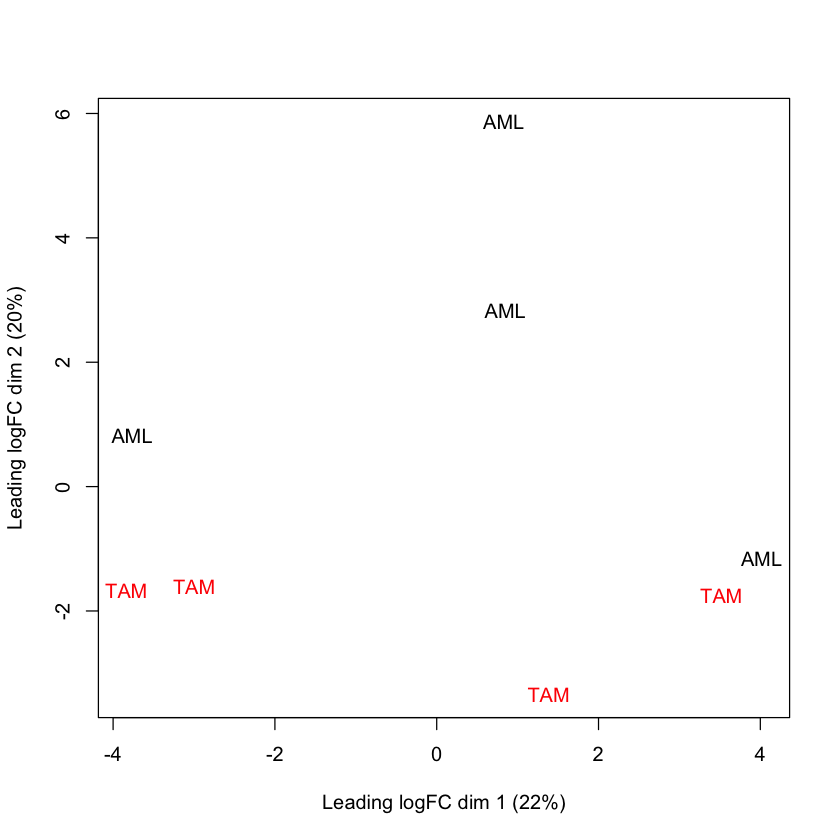

In [46]:
# MDS Plot - can we separate the samples well?
logCPM <- cpm(dge, log=TRUE, prior.count=3)
plotMDS(logCPM,labels=coldata$condition,top=10, col=c(rep(c("red","black"),3)))

In [47]:
head(logCPM)

,PAUVKY.03A,PAUVKY.40A,PAWSNZ.03A,PAWSNZ.40A,PAUTLA.03A,PAUTLA.40A,PAVUDU.03A,PAVUDU.40A
248,14.60235,14.734720,15.000096,14.75202,14.61070,14.80829,14.71454,14.79795
330,11.55150,11.689768,11.339231,11.72364,11.76165,11.75913,11.44837,11.35076
331,11.17377,10.946101,10.917609,10.91151,11.16281,10.87974,11.12991,10.84792
334,11.32683,3.039707,11.308220,11.73346,11.49978,11.67209,11.24822,11.31295
335,12.56432,12.768986,3.039707,12.91446,12.72487,12.86784,12.51752,12.63087
363,10.93369,10.607848,11.407879,11.77923,10.49241,11.23243,10.48941,10.04950


In [48]:
head(dge,2)

An object of class "DGEList"
$counts
    PAUVKY.03A PAUVKY.40A PAWSNZ.03A PAWSNZ.40A PAUTLA.03A PAUTLA.40A
248       8847       7866      14271       4775      13061       6926
330       1065        951       1125        584       1809        835
    PAVUDU.03A PAVUDU.40A
248      11508      13487
330       1193       1233

$samples
           group lib.size norm.factors
PAUVKY.03A     1   361564    0.9840147
PAUVKY.40A     1   271667    1.0623024
PAWSNZ.03A     1   476242    0.9146388
PAWSNZ.40A     1   152974    1.1315621
PAUTLA.03A     1   564077    0.9257923
PAUTLA.40A     1   245598    0.9831875
PAVUDU.03A     1   437469    0.9787275
PAVUDU.40A     1   456452    1.0375536

In [49]:
fit <- lmFit(logCPM, design)
fit <- eBayes(fit, trend=TRUE)
de_results <- topTable(fit, coef=ncol(design), n=Inf) 
lookup <- rownames(de_results)
length(featureData[lookup,2])
head(featureData[lookup,2])

[1] 165

[1] "EEF1G" "RPS8"  "RPS2"  "RACK1" "RPS3A" "RPS3A"

In [50]:
# There are too many values - lets reduce the size a bit more
# Assuming you have the 'de_results' object from topTable
fold_change_threshold <- 5
adjusted_pvalue_threshold <- 0.05

# Select genes that meet both fold change and adjusted p-value criteria
significant_genes <- de_results[
  abs(de_results$logFC) > fold_change_threshold &
  de_results$adj.P.Val < adjusted_pvalue_threshold,
]
dim(significant_genes)

[1] 162   6

In [51]:
lookup <- rownames(significant_genes)
df <- as.data.frame(coldata[,c("condition","patient")])

significant_expression <- dge[lookup,]
dim(significant_expression)
length(lookup)

[1] 162   8

[1] 162

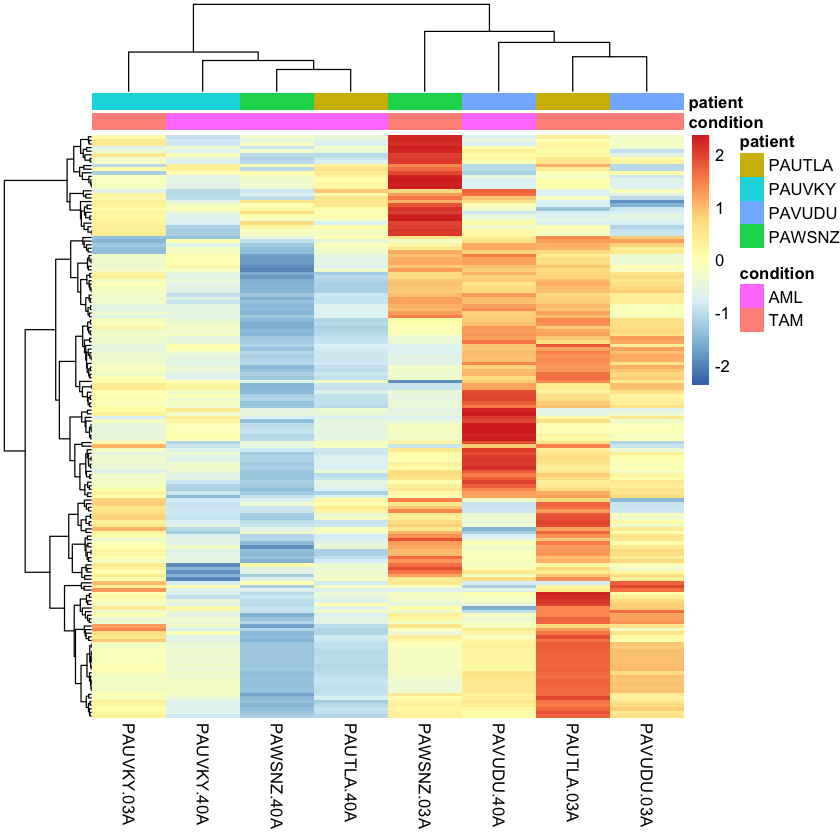

In [52]:
library("pheatmap")

significant_out <- pheatmap(significant_expression, 
                            cluster_rows5=TRUE, 
                            show_rownames=FALSE,
                            cluster_cols=TRUE, 
                            annotation_col=df, 
                            scale="row",
                            clustering_method = "ward.D2",
                            clustering_distance_cols = "minkowski", 
                            clustering_distance_rows = "minkowski" )

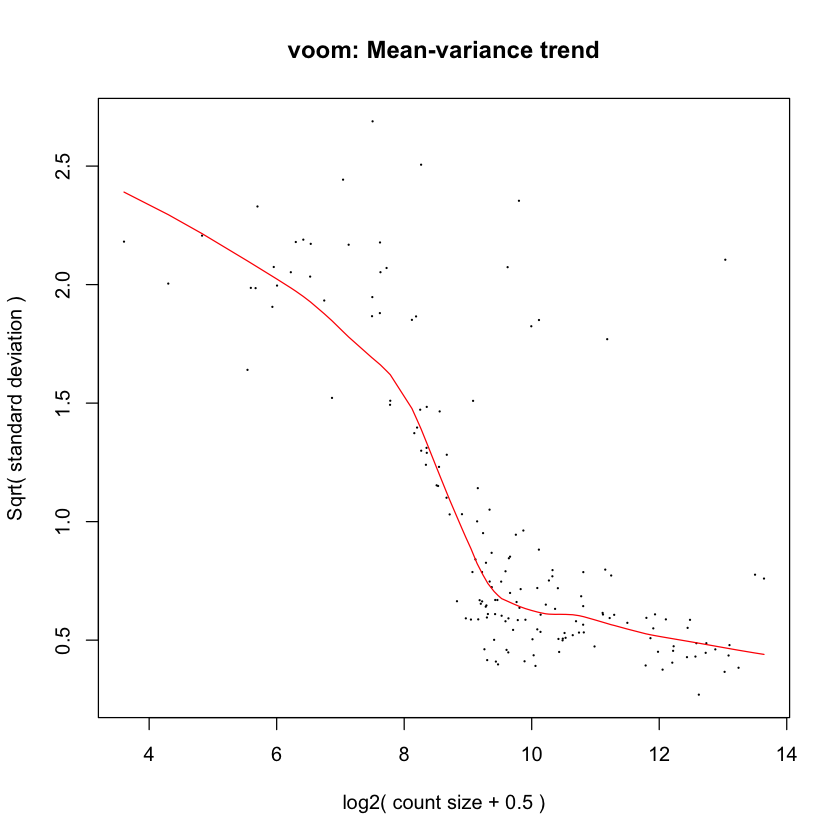

In [53]:
# weighting 
v <- voom(dge, plot=TRUE, normalize="quantile")

In [54]:
vfit <- lmFit(v, design)
vfit <- eBayes(vfit, trend=TRUE)
de_results <- topTable(vfit, coef=ncol(design), n=Inf) 
lookup <- rownames(de_results)
length(featureData[lookup,2])
head(featureData[lookup,2])

[1] 165

[1] "RPS2"   "RPL13A" "EEF1G"  "RPS3A"  "RPS8"   "RPS3A"

In [55]:
# Assuming you have the 'de_results' object from topTable
fold_change_threshold <- 9
adjusted_pvalue_threshold <- 0.05

# Select genes that meet both fold change and adjusted p-value criteria
significant_genes <- de_results[
  abs(de_results$logFC) > fold_change_threshold &
  de_results$adj.P.Val < adjusted_pvalue_threshold,
]
dim(significant_genes)

[1] 145   6

In [56]:
lookup <- rownames(significant_genes)
significant_expression <- dge[lookup,]

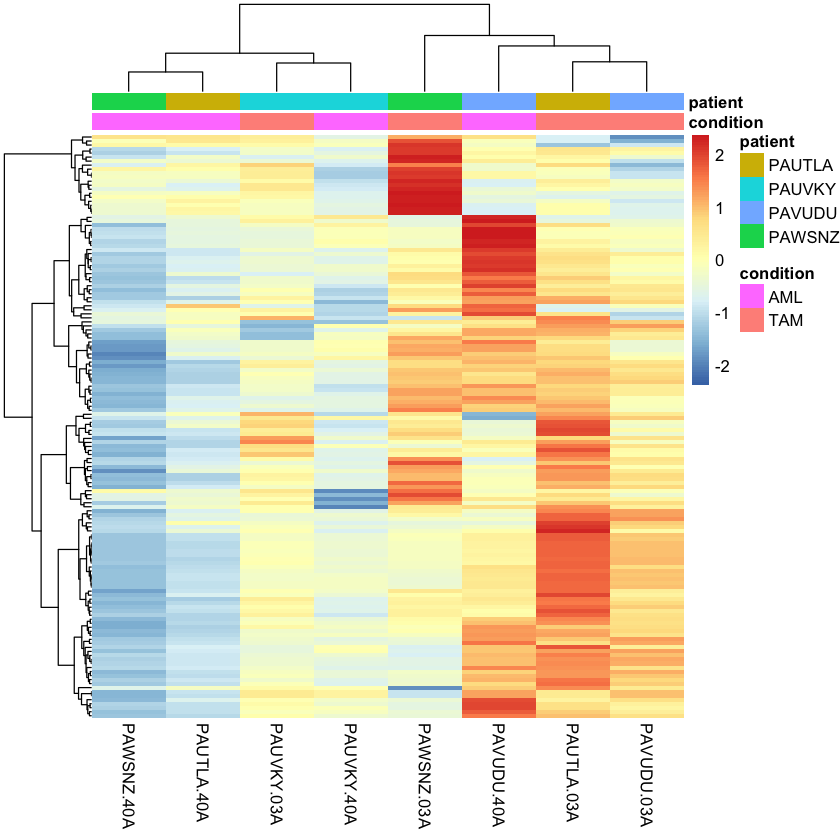

In [57]:
significant_out <- pheatmap(significant_expression, 
                            cluster_rows5=TRUE, 
                            show_rownames=FALSE,
                            cluster_cols=TRUE, 
                            annotation_col=df, 
                            scale="row",
                            clustering_method = "ward.D2",
                            clustering_distance_cols = "minkowski", 
                            clustering_distance_rows = "minkowski" )

In [58]:
featureData[head(rownames(significant_expression),5),2]

[1] "RPS2"   "RPL13A" "EEF1G"  "RPS3A"  "RPS8"

In [59]:
top_gene_list <- as.matrix(featureData[rownames(significant_expression),2])
length(top_gene_list)

[1] 145

In [60]:
top_significant_genes <- dge[rownames(significant_genes),]

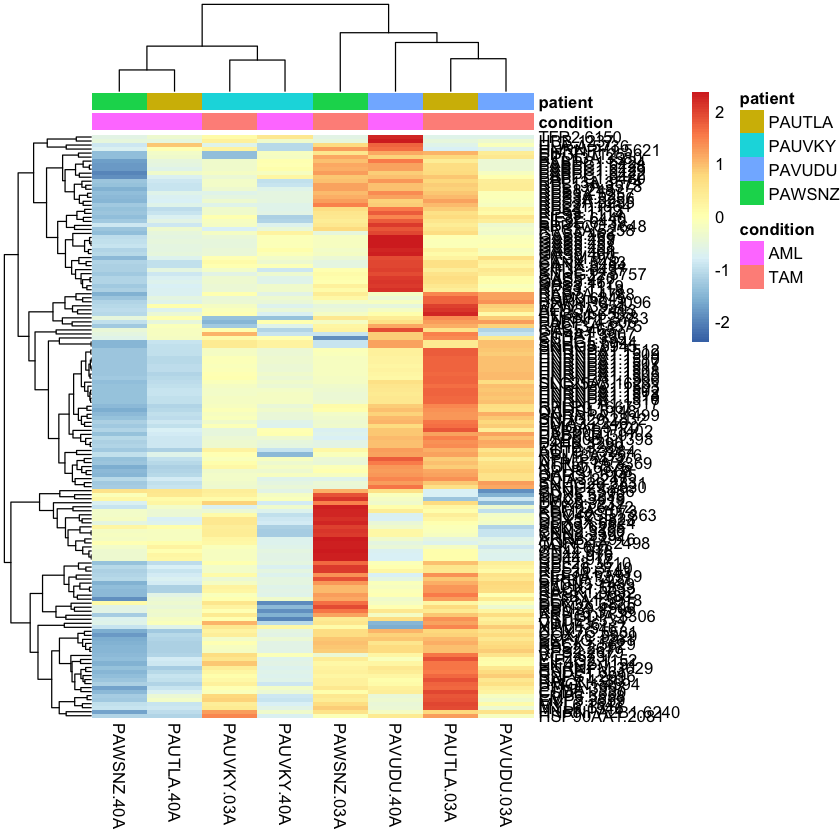

In [61]:
start=1
stop=length(top_gene_list)
date="2024Jun04_SE_voom"
piece <-top_significant_genes[significant_out$tree_row$order[start:stop],]
fd <- data.frame(featureData[rownames(piece),])
genejunction <- paste(featureData[rownames(piece),2],rownames(piece),sep=".")
rownames(fd) <- genejunction
rownames(piece) <- genejunction
outpiece<-pheatmap(piece, cluster_rows5=TRUE, show_rownames=TRUE,
         cluster_cols=TRUE, annotation_col=df, scale="row",clustering_distance_cols = "minkowski", clustering_distance_rows = "minkowski" )
piece_filename <- paste(paste(paste(paste(date,"SE_string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")

# Order by TAM elements, followed by AML elements
piece_exp <- piece[,c(1,3,5,7,2,4,6,8)]
colnames(piece_exp) <- colnames(piece[,c(1,3,5,7,2,4,6,8)])
rownames(piece_exp) <- rownames(piece)
string_filename <- paste(paste(paste(paste(date,"SE_string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
piece_exp_filename <- paste(paste(paste(paste(date,"SE_expression_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
write.csv(piece_exp$counts,piece_exp_filename,quote=FALSE)
write.csv(rownames(piece),piece_filename,quote=FALSE,row.names=FALSE)
write.csv(fd[,2],string_filename,quote=FALSE,row.names=FALSE)

In [62]:
#If you want something like gene-to-cluster assignment, you can 'cut' your row dendrogram into a pre-selected number of groups as follows:
# -- inspecating above the rows seem to fall into 7 groups
clusters<- as.matrix(row_clusters<- sort(cutree(significant_out$tree_row, k=7)),nrows=dim(top_genes_expression)[1],ncols=1)
genes_in_clusters = featureData[rownames(clusters),2]
genes_in_clusters.df <- data.frame(featureData[rownames(clusters),2], clusters)
colnames(genes_in_clusters.df) <- c("geneSymbol","cluster")
dim(genes_in_clusters.df)
cluster_1_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 1,]
cluster_2_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 2,]
cluster_3_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 3,]
cluster_4_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 4,]
cluster_5_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 5,]
cluster_6_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 6,]
cluster_7_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 7,]

cluster_1_filename <- paste(paste(date, "cluster_1", sep="_"),"csv",sep=".")
cluster_2_filename <- paste(paste(date, "cluster_2", sep="_"),"csv",sep=".")
cluster_3_filename <- paste(paste(date, "cluster_3", sep="_"),"csv",sep=".")
cluster_4_filename <- paste(paste(date, "cluster_4", sep="_"),"csv",sep=".")
cluster_5_filename <- paste(paste(date, "cluster_5", sep="_"),"csv",sep=".")
cluster_6_filename <- paste(paste(date, "cluster_6", sep="_"),"csv",sep=".")
cluster_7_filename <- paste(paste(date, "cluster_7", sep="_"),"csv",sep=".")

write.csv(cluster_1_genes$geneSymbol,cluster_1_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_2_genes$geneSymbol,cluster_2_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_3_genes$geneSymbol,cluster_3_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_4_genes$geneSymbol,cluster_4_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_5_genes$geneSymbol,cluster_5_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_6_genes$geneSymbol,cluster_6_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_7_genes$geneSymbol,cluster_7_filename,quote=FALSE,row.names=FALSE)


[1] 145   2

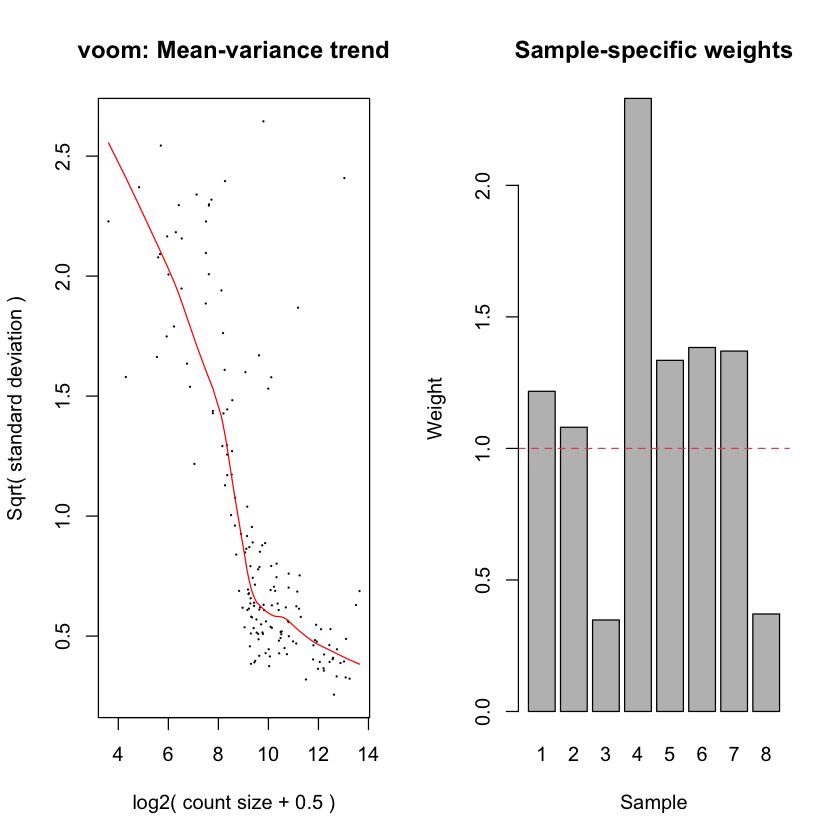

In [63]:
vwts <- voomWithQualityWeights(dge, design=design, normalize.method="quantile", plot=TRUE)

In [64]:
vwtsfit <- lmFit(vwts, design, weights = vwts$weights )
# no other weighting at this time.
 #* c(1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0))

In [65]:
vwtsfit <- eBayes(vwtsfit, trend=TRUE)
de_results <- topTable(vwtsfit, coef=ncol(design), n=Inf) 
lookup <- rownames(de_results)
length(featureData[lookup,2])
head(featureData[lookup,2])

[1] 165

[1] "RPS8"   "RPS3A"  "RPS2"   "EEF1G"  "RPL13A" "PABPC1"

In [66]:
# Assuming you have the 'de_results' object from topTable
fold_change_threshold <- 9
adjusted_pvalue_threshold <- 0.05

# Select genes that meet both fold change and adjusted p-value criteria
significant_genes <- de_results[
  abs(de_results$logFC) > fold_change_threshold &
  de_results$adj.P.Val < adjusted_pvalue_threshold,
]
dim(significant_genes)

[1] 140   6

In [67]:
lookup <- rownames(significant_genes)
significant_expression <- dge[lookup,]

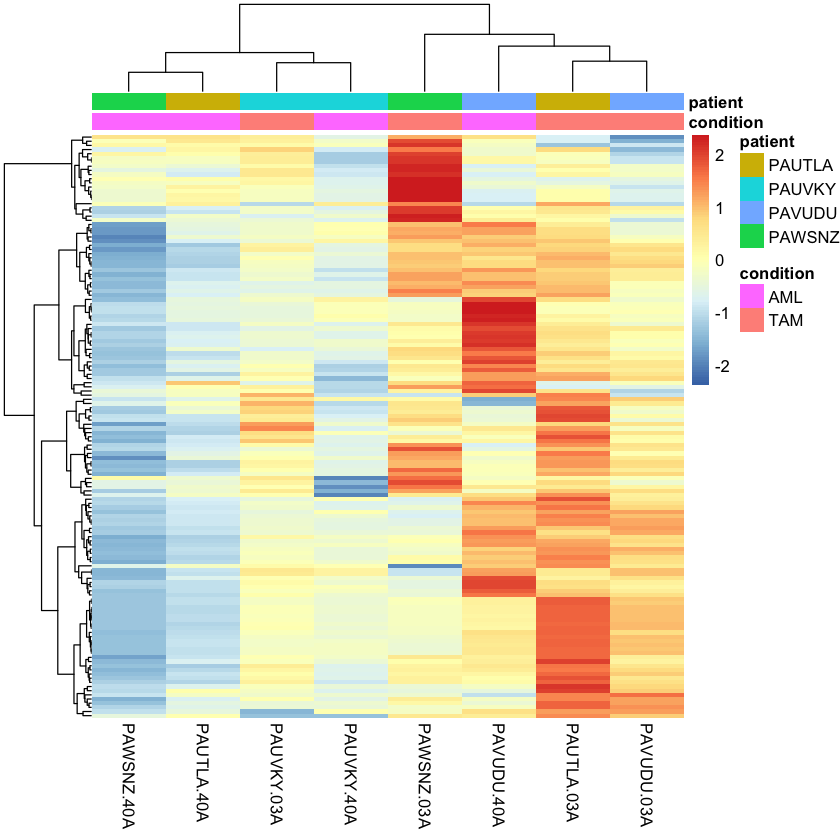

In [68]:
significant_out <- pheatmap(significant_expression, 
                            cluster_rows5=TRUE, 
                            show_rownames=FALSE,
                            cluster_cols=TRUE, 
                            annotation_col=df, 
                            scale="row",
                            clustering_method = "ward.D2",
                            clustering_distance_cols = "minkowski", 
                            clustering_distance_rows = "minkowski" )

In [69]:
featureData[head(rownames(significant_expression),5),2]

[1] "RPS8"   "RPS3A"  "RPS2"   "EEF1G"  "RPL13A"

In [70]:
top_gene_list <- as.matrix(featureData[rownames(significant_expression),2])
length(top_gene_list)

[1] 140

In [71]:
top_significant_genes <- dge[rownames(significant_genes),]

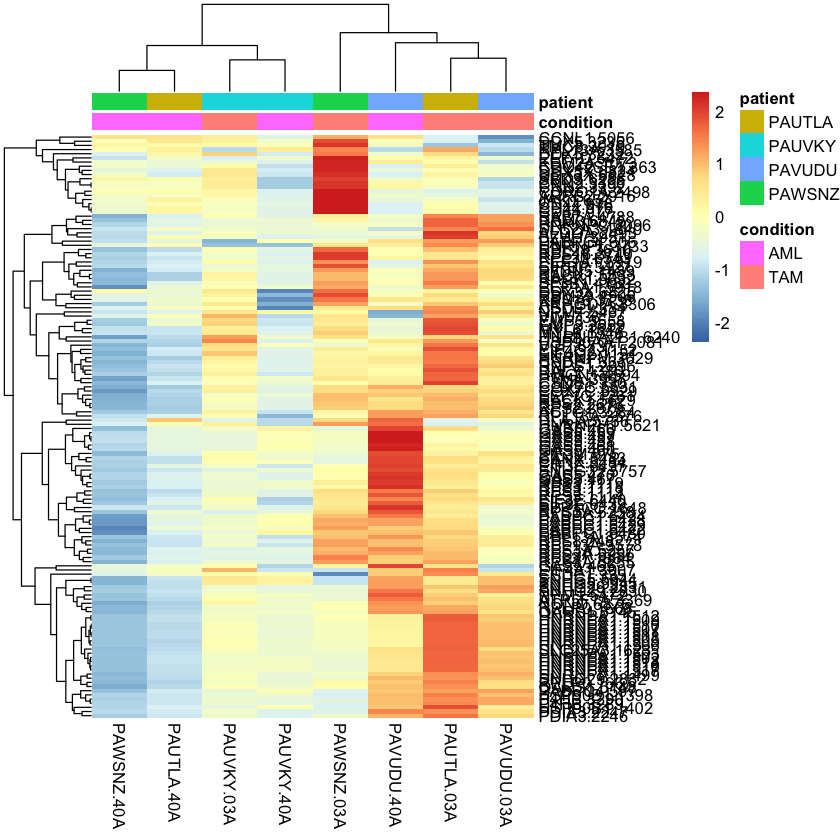

In [72]:
start=1
stop=length(top_gene_list)
date="2024Jun04_SE_vwts"
piece <-top_significant_genes[significant_out$tree_row$order[start:stop],]
fd <- data.frame(featureData[rownames(piece),])
genejunction <- paste(featureData[rownames(piece),2],rownames(piece),sep=".")
rownames(fd) <- genejunction
rownames(piece) <- genejunction
outpiece<-pheatmap(piece, cluster_rows5=TRUE, show_rownames=TRUE,
         cluster_cols=TRUE, annotation_col=df, scale="row",clustering_distance_cols = "minkowski", clustering_distance_rows = "minkowski" )
piece_filename <- paste(paste(paste(paste(date,"SE_string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")

# Order by TAM elements, followed by AML elements
piece_exp <- piece[,c(1,3,5,7,2,4,6,8)]
colnames(piece_exp) <- colnames(piece[,c(1,3,5,7,2,4,6,8)])
rownames(piece_exp) <- rownames(piece)
string_filename <- paste(paste(paste(paste(date,"SE_string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
piece_exp_filename <- paste(paste(paste(paste(date,"SE_expression_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
write.csv(piece_exp$counts,piece_exp_filename,quote=FALSE)
write.csv(rownames(piece),piece_filename,quote=FALSE,row.names=FALSE)
write.csv(fd[,2],string_filename,quote=FALSE,row.names=FALSE)

In [73]:
save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}
save_pheatmap_pdf(outpiece, "2024Jun04_SE_vwts_10fold_top_significant_genes.pdf")

pdf 
  2

In [74]:
#If you want something like gene-to-cluster assignment, you can 'cut' your row dendrogram into a pre-selected number of groups as follows:
# -- inspecating above the rows seem to fall into 7 groups
clusters<- as.matrix(row_clusters<- sort(cutree(significant_out$tree_row, k=7)),nrows=dim(top_genes_expression)[1],ncols=1)
genes_in_clusters = featureData[rownames(clusters),2]
genes_in_clusters.df <- data.frame(featureData[rownames(clusters),2], clusters)
colnames(genes_in_clusters.df) <- c("geneSymbol","cluster")
dim(genes_in_clusters.df)
cluster_1_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 1,]
cluster_2_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 2,]
cluster_3_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 3,]
cluster_4_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 4,]
cluster_5_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 5,]
cluster_6_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 6,]
cluster_7_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 7,]

cluster_1_filename <- paste(paste(date, "cluster_1", sep="_"),"csv",sep=".")
cluster_2_filename <- paste(paste(date, "cluster_2", sep="_"),"csv",sep=".")
cluster_3_filename <- paste(paste(date, "cluster_3", sep="_"),"csv",sep=".")
cluster_4_filename <- paste(paste(date, "cluster_4", sep="_"),"csv",sep=".")
cluster_5_filename <- paste(paste(date, "cluster_5", sep="_"),"csv",sep=".")
cluster_6_filename <- paste(paste(date, "cluster_6", sep="_"),"csv",sep=".")
cluster_7_filename <- paste(paste(date, "cluster_7", sep="_"),"csv",sep=".")

write.csv(cluster_1_genes$geneSymbol,cluster_1_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_2_genes$geneSymbol,cluster_2_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_3_genes$geneSymbol,cluster_3_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_4_genes$geneSymbol,cluster_4_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_5_genes$geneSymbol,cluster_5_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_6_genes$geneSymbol,cluster_6_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_7_genes$geneSymbol,cluster_7_filename,quote=FALSE,row.names=FALSE)


[1] 140   2